In [ ]:
import math
import os
import mldatasets
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics, tree
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import xgboost as xgb
from rulefit import RuleFit
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from alepython import ale_plot

In [2]:
print(tf.__version__)

2.2.0


In [3]:
fueleconomy_df = mldatasets.load("vehicle-fueleconomy", prepare=True)

https://www.fueleconomy.gov/feg/epadata/vehicles.csv.zip downloaded to /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter5/data/vehicles.csv.zip
/Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter5/data/vehicles.csv.zip uncompressed to /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter5/data/vehicles.csv
1 dataset files found in /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter5/data/vehicles.csv folder
parsing /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter5/data/vehicles.csv/vehicles.csv


In [4]:
fueleconomy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43221 entries, 0 to 43220
Data columns (total 84 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   make                                       43221 non-null  object 
 1   model                                      43221 non-null  object 
 2   year                                       43221 non-null  int16  
 3   cylinders                                  43221 non-null  float32
 4   displ                                      43221 non-null  float32
 5   phevBlended                                43221 non-null  bool   
 6   co2TailpipeGpm                             43221 non-null  float32
 7   co2                                        43221 non-null  int16  
 8   ghgScore                                   43221 non-null  int16  
 9   pv4                                        43221 non-null  int16  
 10  lv4                   

In [5]:
rand = 9
y = fueleconomy_df['comb08']
X = fueleconomy_df.drop(['comb08','make','model'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                    test_size=0.15, random_state=rand)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,\
                                    test_size=0.2, random_state=rand)

In [112]:
os.environ['PYTHONHASHSEED']=str(rand)
tf.random.set_seed(rand)
np.random.seed(rand)

In [6]:
fitted_nn_model = Sequential([
    tf.keras.Input(shape=[len(X_train.keys())]),
    Normalization(),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
  ])
fitted_nn_model.compile(loss='mean_squared_error',\
                optimizer=Adam(lr = 0.0005),\
                metrics=['mse'])
fitted_nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 81)                163       
_________________________________________________________________
dense (Dense)                (None, 64)                5248      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,636
Trainable params: 9,473
Non-trainable params: 163
_________________________________________________________________


In [7]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,\
                                      patience=200, min_delta=0.0001,\
                                      restore_best_weights=True)
nn_history = fitted_nn_model.fit(\
                X_train.astype(float), y_train.astype(float), epochs=3000, batch_size=128,\
                validation_data=(X_val.astype(float), y_val.astype(float)), verbose=1,\
                                 callbacks=[es])

Epoch 1/3000
230/230 [==============================] - 0s 2ms/step - loss: 348.1830 - mse: 348.1830 - val_loss: 16.0352 - val_mse: 16.0352
Epoch 2/3000
230/230 [==============================] - 0s 2ms/step - loss: 14.1210 - mse: 14.1210 - val_loss: 8.9617 - val_mse: 8.9617
Epoch 3/3000
230/230 [==============================] - 0s 1ms/step - loss: 8.6600 - mse: 8.6600 - val_loss: 5.2343 - val_mse: 5.2343
Epoch 4/3000
230/230 [==============================] - 0s 2ms/step - loss: 5.9426 - mse: 5.9426 - val_loss: 3.8764 - val_mse: 3.8764
Epoch 5/3000
230/230 [==============================] - 0s 1ms/step - loss: 5.0111 - mse: 5.0111 - val_loss: 3.3182 - val_mse: 3.3182
Epoch 6/3000
230/230 [==============================] - 0s 2ms/step - loss: 4.4907 - mse: 4.4907 - val_loss: 3.2830 - val_mse: 3.2830
Epoch 7/3000
230/230 [==============================] - 0s 1ms/step - loss: 4.3282 - mse: 4.3282 - val_loss: 2.7793 - val_mse: 2.7793
Epoch 8/3000
230/230 [==============================] 

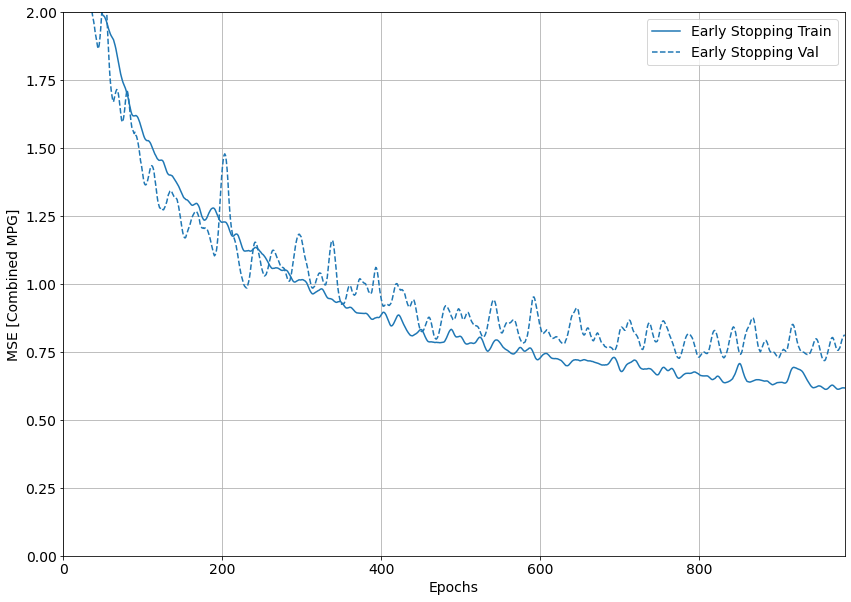

In [24]:
nn_plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
nn_plotter.plot({'Early Stopping': nn_history}, metric = "mse")
plt.rc("figure", figsize=(14, 10))
plt.rcParams.update({'font.size': 14})
plt.ylabel('MSE [Combined MPG]')
plt.ylim([0, 2])
plt.show()

In [22]:
y_train_nn_pred = fitted_nn_model(X_train.astype(float))
y_test_nn_pred = fitted_nn_model.predict(X_test.astype(float))
RMSE_nn_train = metrics.mean_squared_error(y_train,\
                                        y_train_nn_pred, squared=False)
RMSE_nn_test = metrics.mean_squared_error(y_test,\
                                        y_test_nn_pred, squared=False)
R2_nn_test = metrics.r2_score(y_test, y_test_nn_pred)
print('RMSE_train: %.4f\tRMSE_test: %.4f\tr2: %.4f' %\
                    (RMSE_nn_train, RMSE_nn_test, R2_nn_test))

RMSE_train: 0.7012	RMSE_test: 0.7878	r2: 0.9907


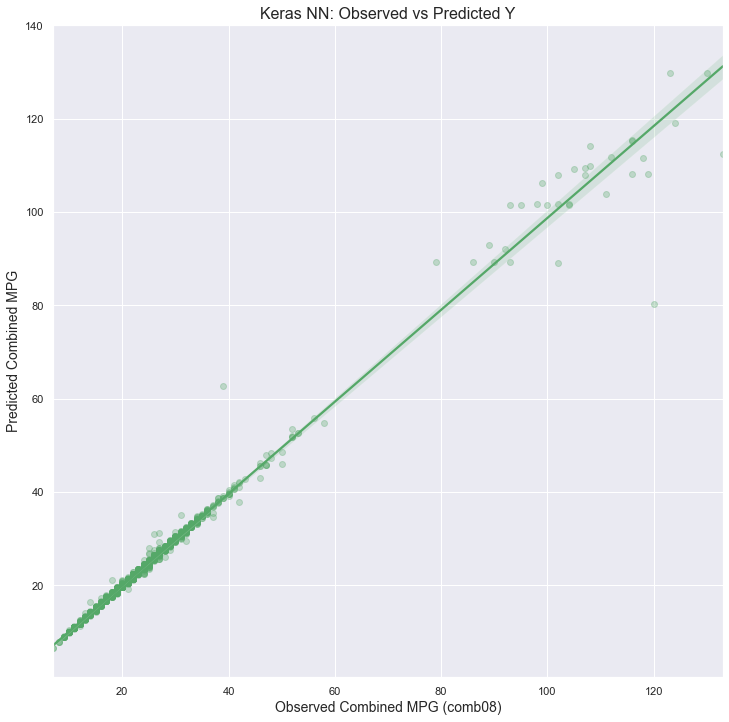

In [25]:
sns.set()
plt.figure(figsize = (12,12))
plt.title('Keras NN: Observed vs Predicted Y', fontsize=16)
plt.ylabel('Predicted Combined MPG', fontsize=14)
sns.regplot(x=y_test, y=y_test_nn_pred, color="g",\
            scatter_kws={'alpha':0.3})
plt.xlabel('Observed Combined MPG (comb08)', fontsize=14)
plt.show() 

In [26]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [12]:
fitted_xgb_model = xgb.XGBRegressor(max_depth=7, learning_rate=0.6,\
                    n_jobs=4, objective='reg:squarederror',\
                    random_state=rand, n_estimators=50).\
                    fit(X_train, y_train,\
                    eval_set=[(X_train, y_train),(X_val, y_val)],\
                    eval_metric='rmse')

[0]	validation_0-rmse:8.90050	validation_1-rmse:9.01804
[1]	validation_0-rmse:3.66654	validation_1-rmse:3.75625
[2]	validation_0-rmse:1.61428	validation_1-rmse:1.74554
[3]	validation_0-rmse:0.84903	validation_1-rmse:0.99170
[4]	validation_0-rmse:0.59878	validation_1-rmse:0.80051
[5]	validation_0-rmse:0.52188	validation_1-rmse:0.75982
[6]	validation_0-rmse:0.47649	validation_1-rmse:0.73936
[7]	validation_0-rmse:0.45505	validation_1-rmse:0.73265
[8]	validation_0-rmse:0.43781	validation_1-rmse:0.73321
[9]	validation_0-rmse:0.42618	validation_1-rmse:0.73364
[10]	validation_0-rmse:0.40978	validation_1-rmse:0.72558
[11]	validation_0-rmse:0.40061	validation_1-rmse:0.73562
[12]	validation_0-rmse:0.39194	validation_1-rmse:0.73860
[13]	validation_0-rmse:0.38958	validation_1-rmse:0.73902
[14]	validation_0-rmse:0.38661	validation_1-rmse:0.74116
[15]	validation_0-rmse:0.38497	validation_1-rmse:0.74049
[16]	validation_0-rmse:0.38299	validation_1-rmse:0.73959
[17]	validation_0-rmse:0.38033	validation

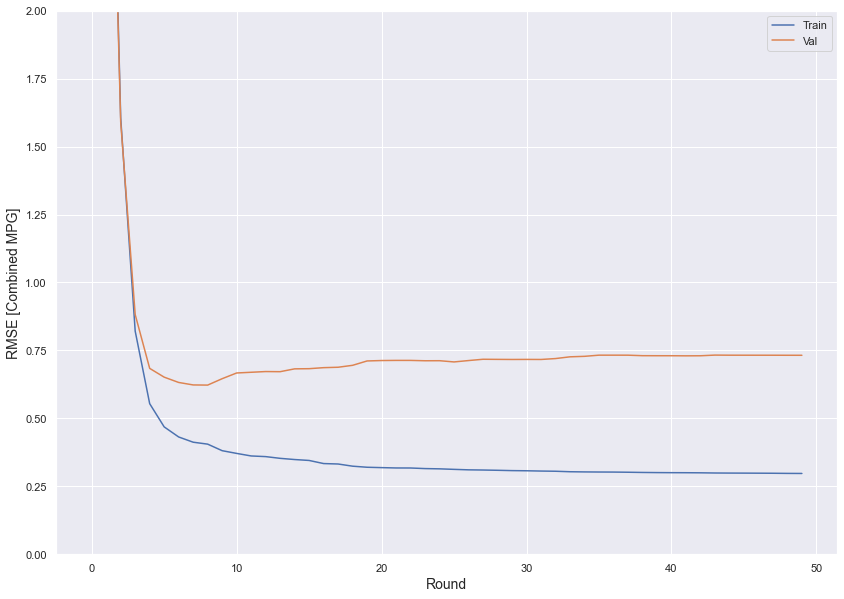

In [72]:
plt.figure(figsize=(14, 10))
plt.rcParams.update({'font.size': 14})
plt.plot(fitted_xgb_model.evals_result()['validation_0']['rmse'])
plt.plot(fitted_xgb_model.evals_result()['validation_1']['rmse'])
plt.ylabel('RMSE [Combined MPG]', fontsize=14)
plt.ylim([0, 2])
plt.xlabel('Round', fontsize=14)
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [69]:
y_train_xgb_pred = fitted_xgb_model.predict(X_train)
y_test_xgb_pred = fitted_xgb_model.predict(X_test)
RMSE_xgb_train = math.sqrt(\
                    metrics.mean_squared_error(y_train,\
                                               y_train_xgb_pred))
RMSE_xgb_test = math.sqrt(\
                    metrics.mean_squared_error(y_test,
                                               y_test_xgb_pred))
R2_xgb_test = metrics.r2_score(y_test, y_test_xgb_pred)
print('RMSE_train: %.4f\tRMSE_test: %.4f\tr2: %.4f' %\
                    (RMSE_xgb_train, RMSE_xgb_test, R2_xgb_test))

RMSE_train: 0.2974	RMSE_test: 0.6809	r2: 0.9930


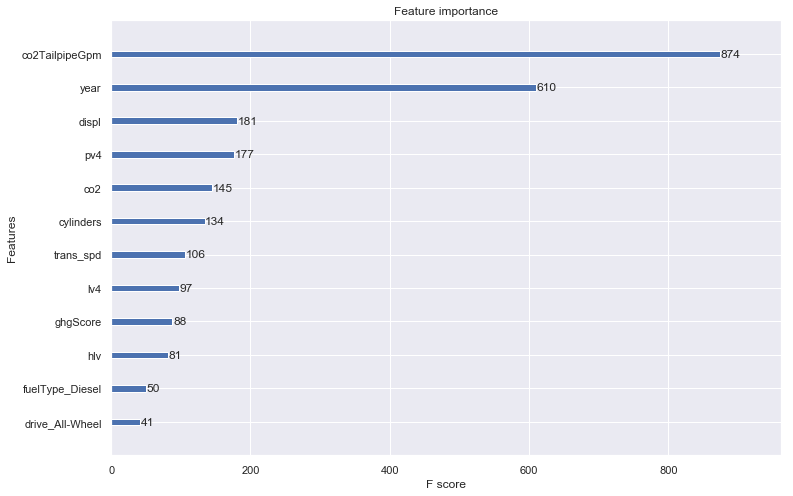

In [14]:
sns.set()
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(fitted_xgb_model, max_num_features=12, ax=ax,\
                    importance_type="weight")
plt.show()

In [15]:
shap_xgb_explainer = shap.TreeExplainer(fitted_xgb_model)

In [33]:
background = X_train.iloc[np.random.choice(X_train.shape[0], 150, replace=False)]
print(background.shape)
shap_nn_explainer = shap.GradientExplainer(fitted_nn_model,\
                                         background.astype(float).values)

(150, 81)


In [16]:
shap_xgb_values_train = shap_xgb_explainer.shap_values(X_train)
print(shap_xgb_values_train.shape)
shap_xgb_values_test = shap_xgb_explainer.shap_values(X_test)
print(shap_xgb_values_test.shape)

(29389, 81)
(6484, 81)


In [34]:
shap_nn_values_test = shap_nn_explainer.shap_values(X_test.astype(float).values)
print(type(shap_nn_values_test))
print(shap_nn_values_test[0].shape)

<class 'list'>
(6484, 81)


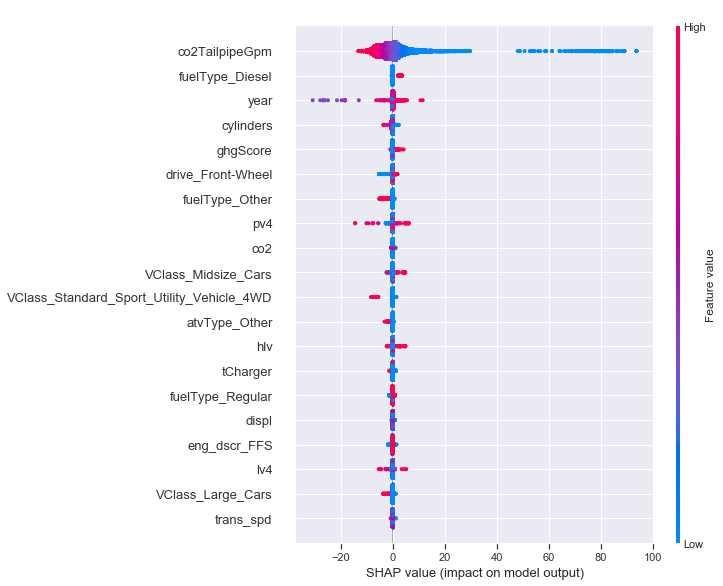

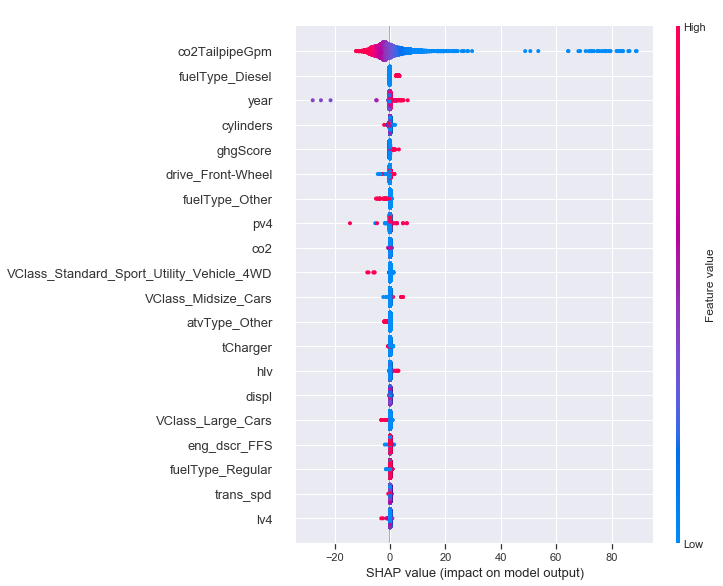

In [20]:
shap.summary_plot(shap_xgb_values_train, X_train, plot_type="dot")
shap.summary_plot(shap_xgb_values_test, X_test, plot_type="dot")

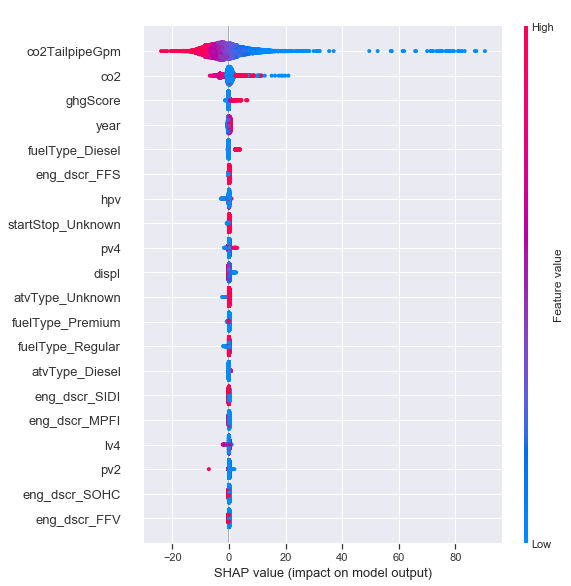

In [35]:
shap.summary_plot(shap_nn_values_test[0], X_test, plot_type="dot")

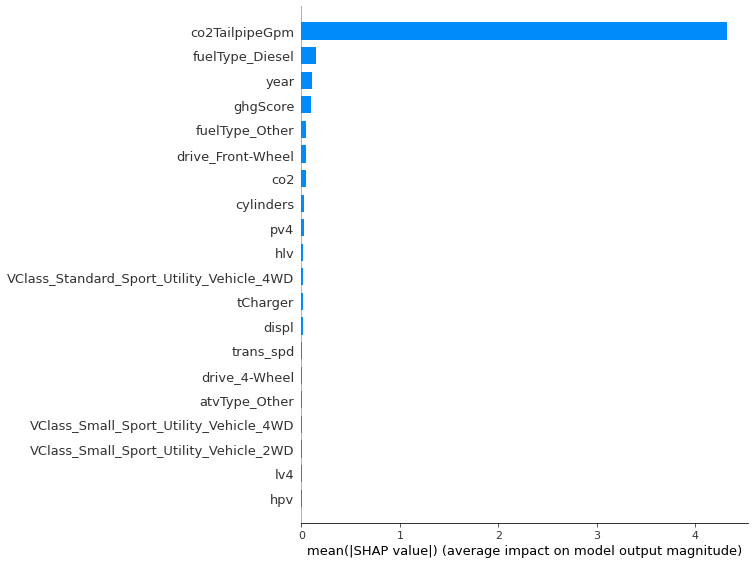

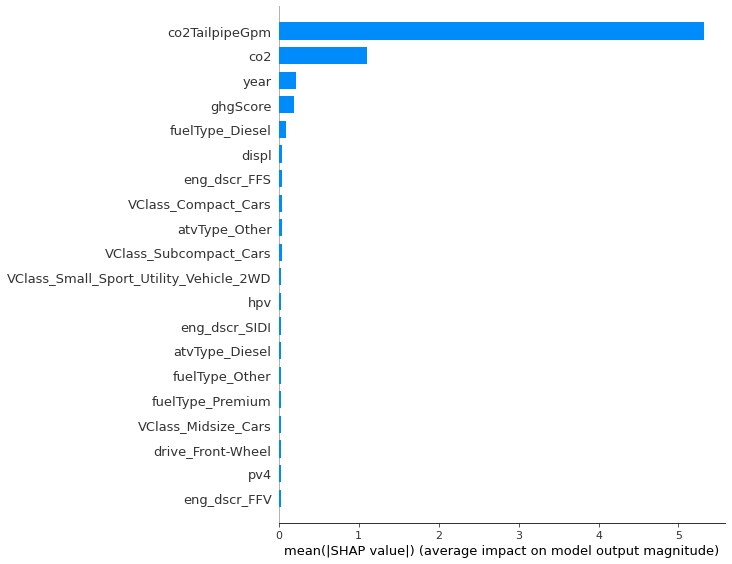

In [57]:
shap.summary_plot(shap_xgb_values_test, X_test, plot_type="bar")
shap.summary_plot(shap_nn_values_test[0], X_test, plot_type="bar")

In [36]:
top_features_l = ['comb08'] + ['co2TailpipeGpm', 'fuelType_Diesel',\
                               'co2', 'year', 'ghgScore', 'cylinders']
top_df = fueleconomy_df.loc[X_train.index, top_features_l]

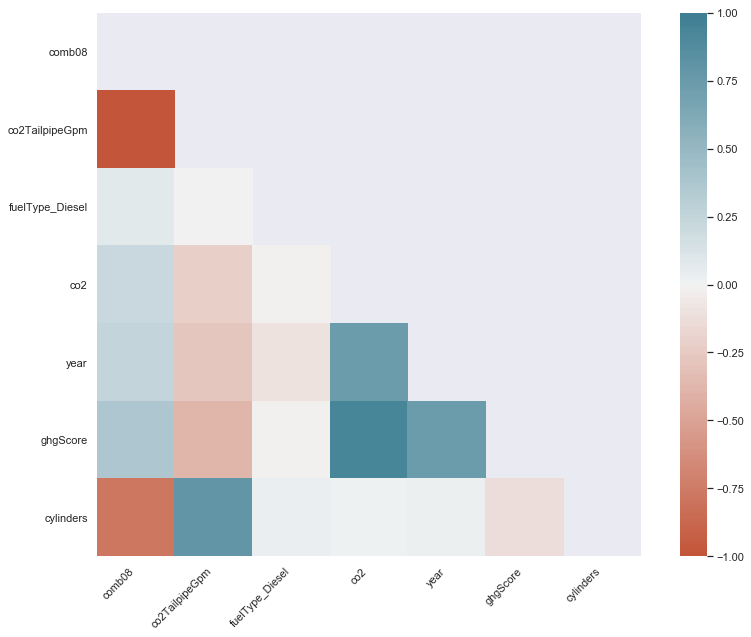

In [37]:
corrs = stats.spearmanr(top_df).correlation
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(
    corrs, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    xticklabels=top_df.columns,
    yticklabels=top_df.columns,
    mask=mask,
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

In [38]:
print('spearman\tco2TailpipeGpm→comb08\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.co2TailpipeGpm.values, top_df.comb08.values)))
print('point-biserial\tfuelType_Diesel→comb08\tcorr: %.3f\tp-val: %.4f' % 
      (stats.pointbiserialr(top_df.fuelType_Diesel.values, top_df.comb08.values)))
print('spearman\tco2→comb08\t\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.co2.values, top_df.comb08.values)))
print('spearman\tyear→comb08\t\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.year.values, top_df.comb08.values)))
print('spearman\tghgScore→comb08\t\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(top_df.ghgScore.values, top_df.comb08.values)))
print('spearman\tcylinders→comb08\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.cylinders.values, top_df.comb08.values)))

spearman	co2TailpipeGpm→comb08	corr: -0.994	p-val: 0.0000
point-biserial	fuelType_Diesel→comb08	corr: 0.062	p-val: 0.0000
spearman	co2→comb08		corr: 0.223	p-val: 0.0000
spearman	year→comb08		corr: 0.255	p-val: 0.0000
spearman	ghgScore→comb08		corr: 0.374	p-val: 0.0000
spearman	cylinders→comb08	corr: -0.785	p-val: 0.0000


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


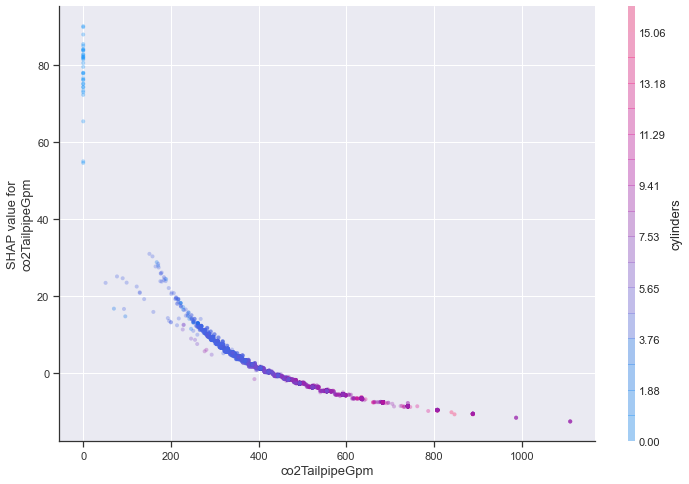

spearman	cylinders→co2TailpipeGpm	corr: 0.787	p-val: 0.0000


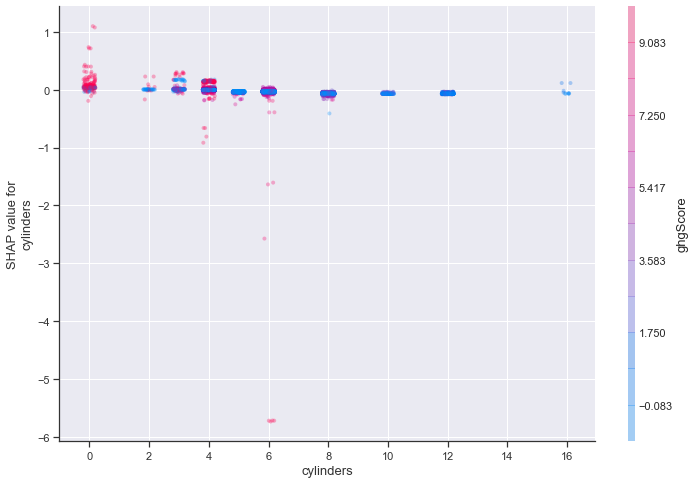

spearman	ghgScore→cylinders		corr: -0.117	p-val: 0.0000


In [24]:
shap.dependence_plot("co2TailpipeGpm", shap_xgb_values_test, X_test,\
                     interaction_index="cylinders", show=False, alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()
print('spearman\tcylinders→co2TailpipeGpm\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.cylinders.values, X_train.co2TailpipeGpm.values)))
shap.dependence_plot("cylinders", shap_xgb_values_train, X_train,\
                     interaction_index="ghgScore", show=False,\
                     x_jitter=0.4, alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()
print('spearman\tghgScore→cylinders\t\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(top_df.ghgScore.values, top_df.cylinders.values)))

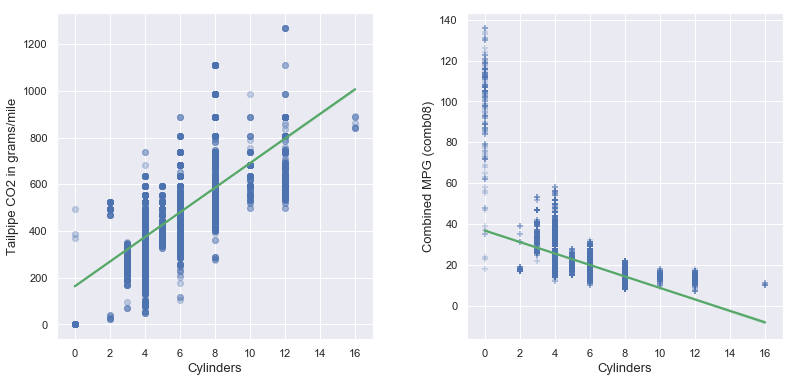

In [26]:
fig, axs = plt.subplots(1, 2, figsize = (13,6))
fig.subplots_adjust(hspace=0, wspace=0.3)
sns.regplot(x=X_train.cylinders, y=X_train.co2TailpipeGpm, ax=axs[0],\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[0].set_ylabel('Tailpipe CO2 in grams/mile', fontsize=13)
axs[0].set_xlabel('Cylinders', fontsize=13)
axs[0].set_xlim([-1,17])
sns.regplot(x=X_train.cylinders, y=y_train, ax=axs[1], marker="+",\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[1].set_ylabel('Combined MPG (comb08)', fontsize=13)
axs[1].set_xlabel('Cylinders', fontsize=13)
axs[1].set_xlim([-1,17])
plt.show() 

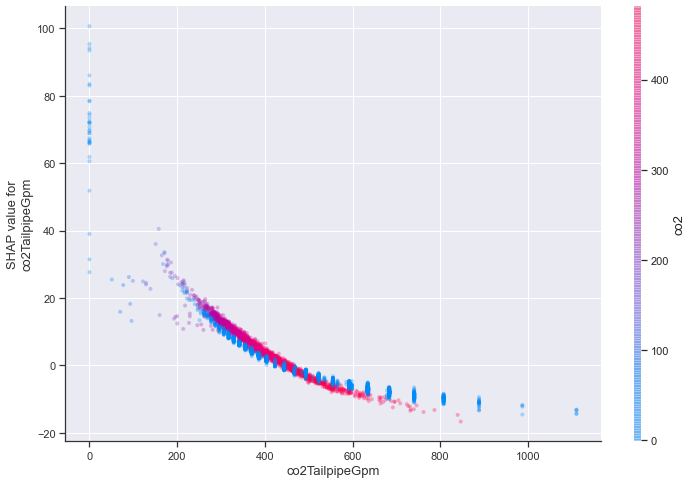

spearman	co2→co2TailpipeGpm	corr: -0.222	p-val: 0.0000


In [67]:
shap.dependence_plot("co2TailpipeGpm", shap_nn_values_test[0],\
                     X_test, alpha=0.3,\
                     interaction_index="co2", show=False)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()
print('spearman\tco2→co2TailpipeGpm\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.co2.values, X_train.co2TailpipeGpm.values)))

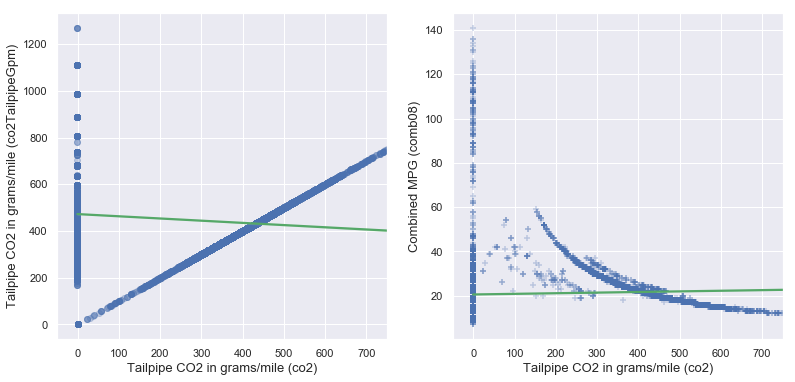

In [40]:
fig, axs = plt.subplots(1, 2, figsize = (13,6))
sns.regplot(x=X_train.co2, y=X_train.co2TailpipeGpm, ax=axs[0],\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[0].set_ylabel('Tailpipe CO2 in grams/mile (co2TailpipeGpm)',\
                  fontsize=13)
axs[0].set_xlabel('Tailpipe CO2 in grams/mile (co2)', fontsize=13)
axs[0].set_xlim([-50, 750])
sns.regplot(x=X_train.co2, y=y_train, ax=axs[1], marker="+",\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[1].set_ylabel('Combined MPG (comb08)', fontsize=13)
axs[1].set_xlabel('Tailpipe CO2 in grams/mile (co2)', fontsize=13)
axs[1].set_xlim([-50, 750])
plt.show() 

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


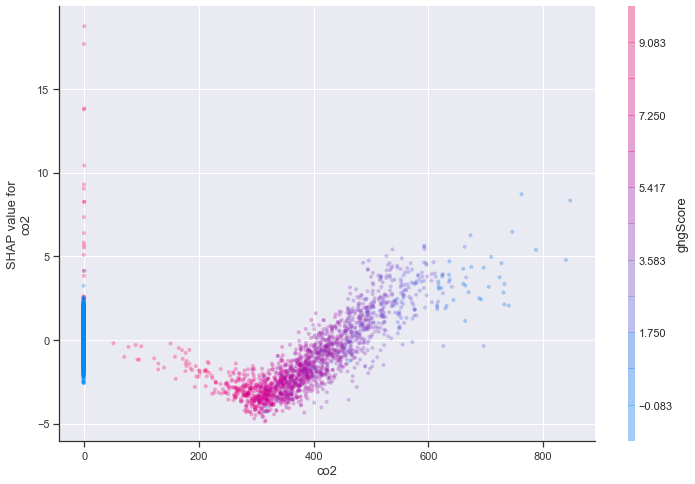

spearman	ghgScore→co2	corr: 0.942	p-val: 0.0000


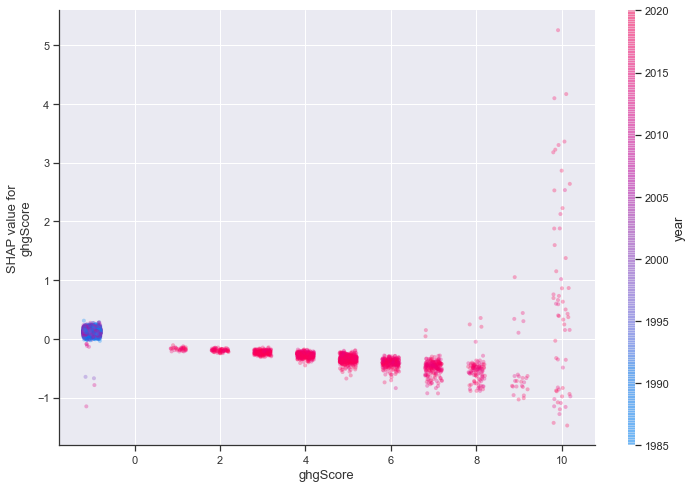

spearman	ghgScore→year	corr: 0.744	p-val: 0.0000


In [29]:
shap.dependence_plot("co2", shap_nn_values_test[0],\
                     X_test, alpha=0.3, x_jitter=10,\
                     interaction_index="ghgScore", show=False)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()
print('spearman\tghgScore→co2\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(top_df.ghgScore.values, top_df.co2.values)))
shap.dependence_plot("ghgScore", shap_nn_values_test[0],\
                     X_test, alpha=0.3, x_jitter=0.4,\
                     interaction_index="year", show=False)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()
print('spearman\tghgScore→year\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(top_df.ghgScore.values, top_df.year.values)))

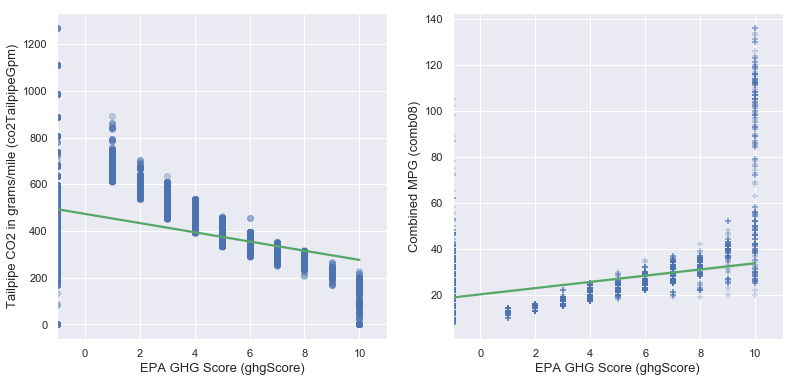

In [32]:
fig, axs = plt.subplots(1, 2, figsize = (13,6))
sns.regplot(x=X_train.ghgScore, y=X_train.co2TailpipeGpm, ax=axs[0],\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[0].set_ylabel('Tailpipe CO2 in grams/mile (co2TailpipeGpm)',\
                  fontsize=13)
axs[0].set_xlabel('EPA GHG Score (ghgScore)', fontsize=13)
axs[0].set_xlim([-1, 11])
sns.regplot(x=X_train.ghgScore, y=y_train, ax=axs[1], marker="+",\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[1].set_ylabel('Combined MPG (comb08)', fontsize=13)
axs[1].set_xlabel('EPA GHG Score (ghgScore)', fontsize=13)
axs[1].set_xlim([-1, 11])
plt.show() 

In [34]:
sample_test_size = 0.05
sample_test_idx = np.random.choice(X_test.shape[0],
                                   math.ceil(X_test.shape[0]*sample_test_size),\
                                   replace=False)
shap.initjs()
shap.force_plot(shap_xgb_explainer.expected_value,\
                shap_xgb_values_test[sample_test_idx],\
                X_test.iloc[sample_test_idx])

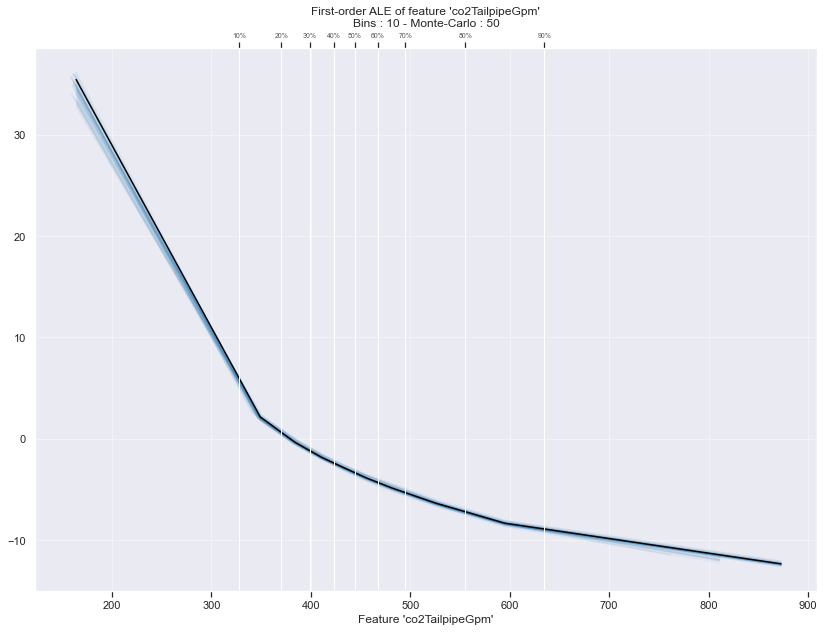

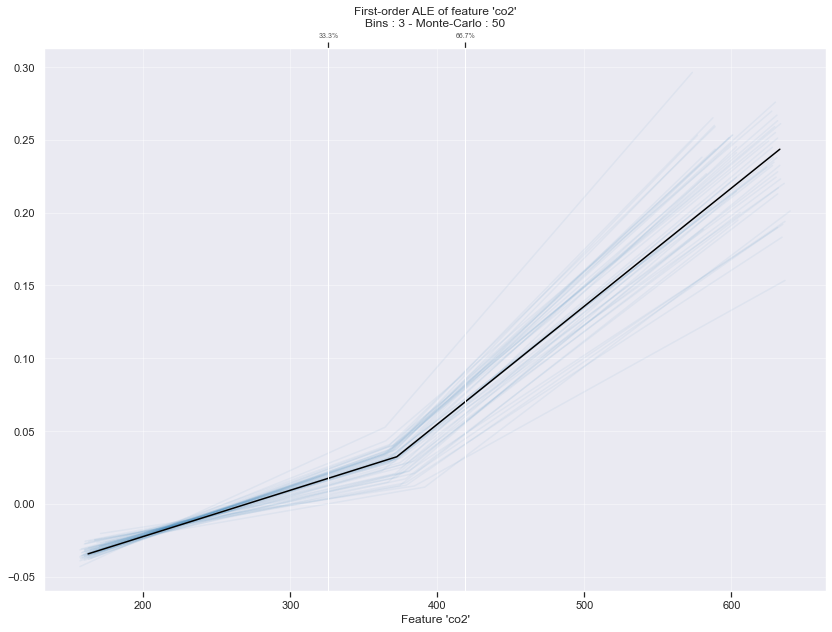

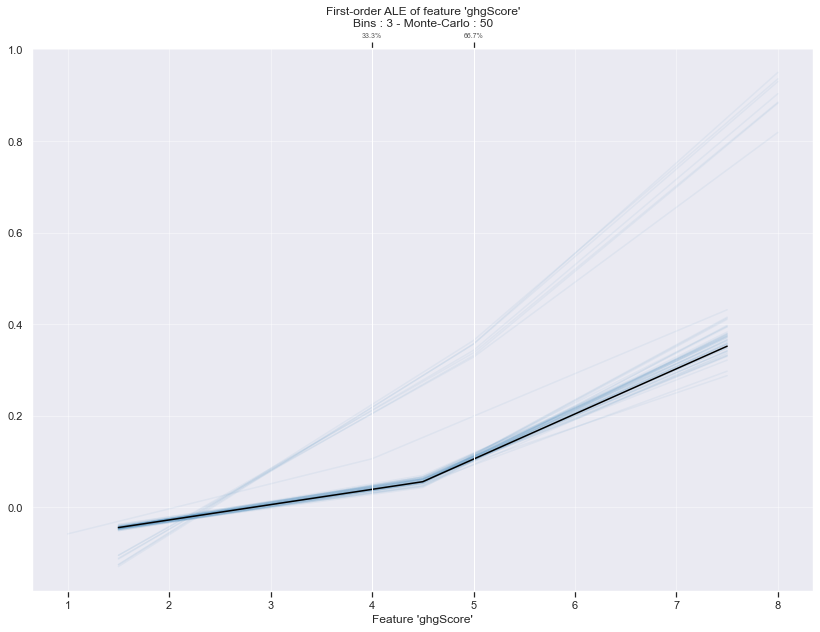

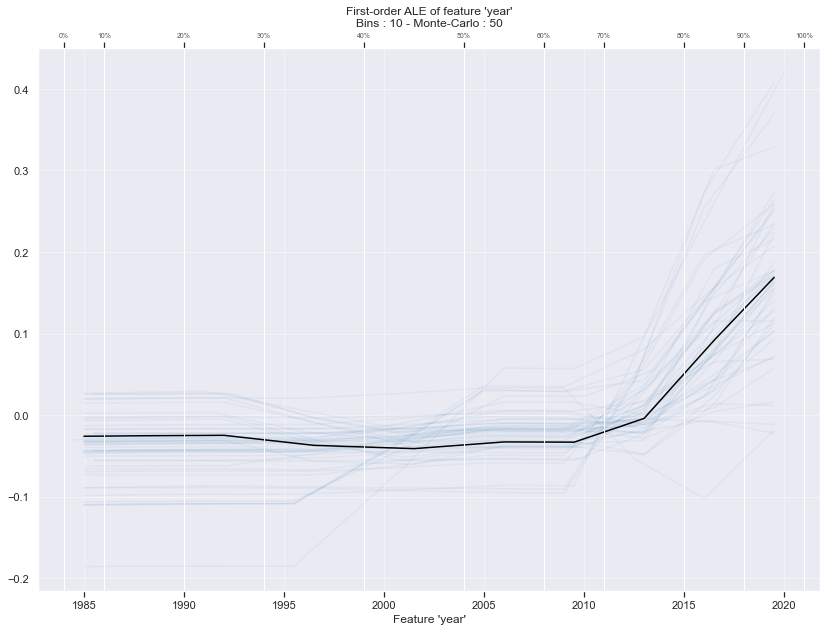

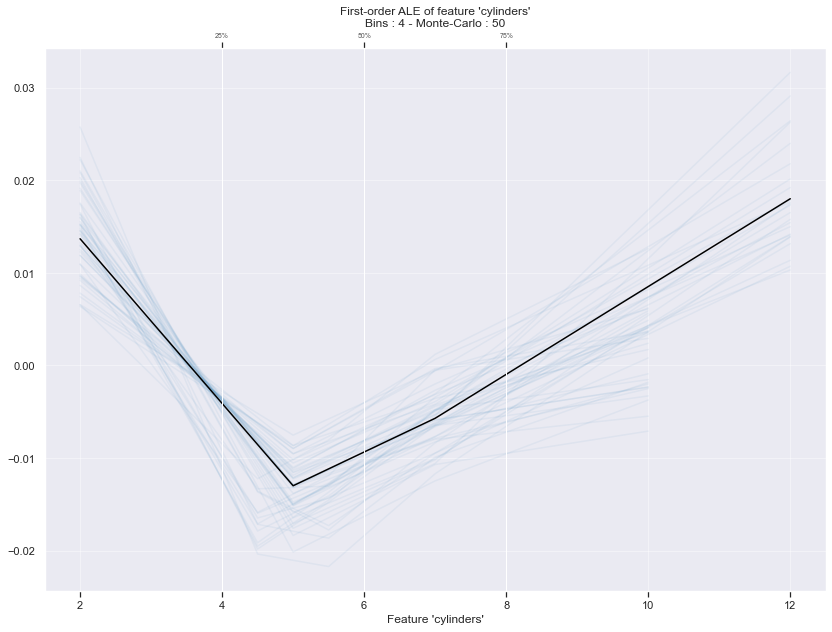

CPU times: user 7min 46s, sys: 2.99 s, total: 7min 49s
Wall time: 7min 20s


In [103]:
%%time
for feature_name in ['co2TailpipeGpm', 'co2', 'ghgScore',\
                     'year', 'cylinders']:
    plt.rc("figure", figsize=(14, 10))
    ale_plot(
        fitted_xgb_model, X_test, [feature_name], bins=10,\
        monte_carlo=True, monte_carlo_rep=50,\
        monte_carlo_ratio=0.4
    )
    plt.show()

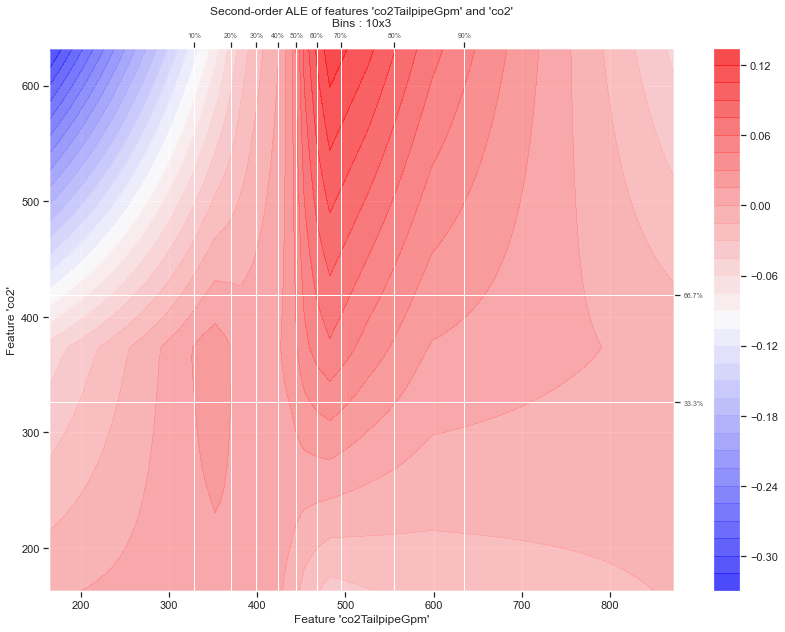

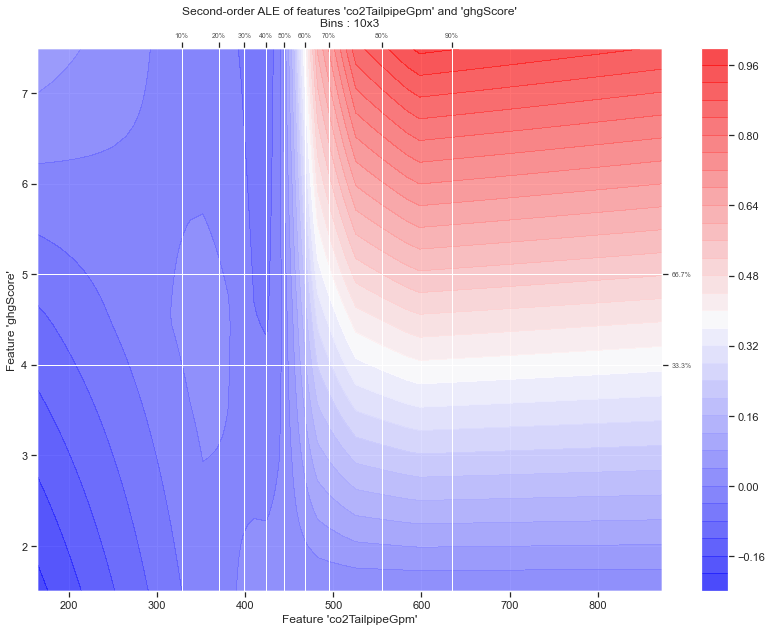

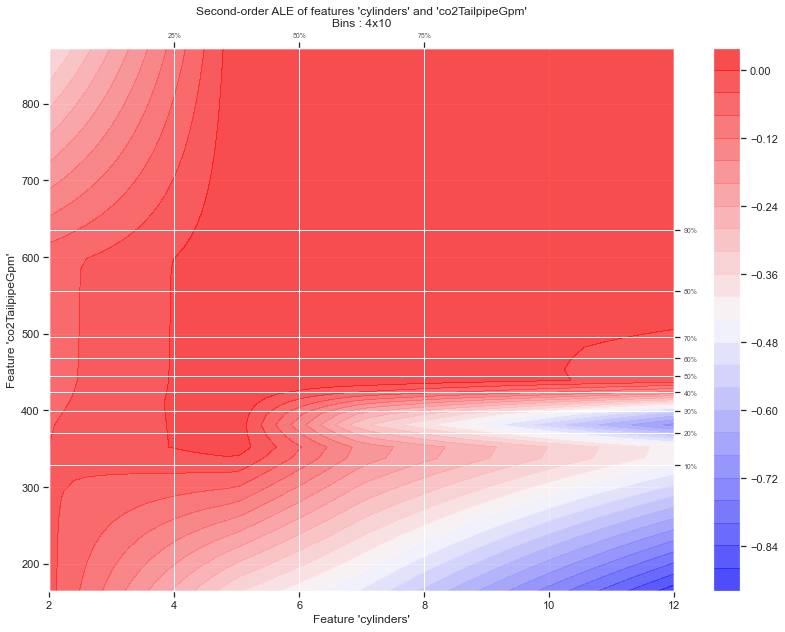

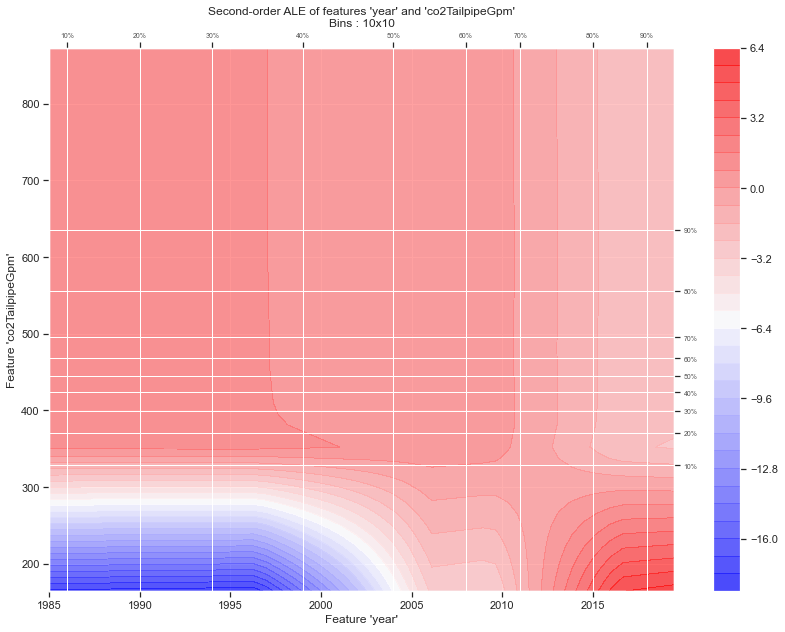

CPU times: user 7.98 s, sys: 571 ms, total: 8.55 s
Wall time: 2.3 s


In [109]:
for interaction in [['co2TailpipeGpm', 'co2'], ['co2TailpipeGpm', 'ghgScore'],\
                    ['cylinders', 'co2TailpipeGpm'], ['year', 'co2TailpipeGpm']]:
    plt.rc("figure", figsize=(14, 10))
    ale_plot(
        fitted_xgb_model, X_test, interaction, bins=[10,10]
    )
    plt.show()

In [121]:
fitted_dt_surrogate = tree.DecisionTreeRegressor(max_depth=7,\
                                                 random_state=rand).\
                                        fit(X_train, y_train_nn_pred)
y_train_dt_pred = fitted_dt_surrogate.predict(X_train)
y_test_dt_pred = fitted_dt_surrogate.predict(X_test)

In [122]:
fitted_rf_surrogate = RuleFit(max_rules=150, rfmode='regress',\
                              random_state=rand, tree_size=8).\
                        fit(X_train.astype(float).values,\
                            np.array(y_train_nn_pred).squeeze(),\
                            X_train.columns)
y_train_rf_pred = fitted_rf_surrogate.predict(X_train.astype(float).values)
y_test_rf_pred = fitted_rf_surrogate.predict(X_test.astype(float).values)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 268.2464748744969, tolerance: 191.94464445215556
  positive)


In [114]:
#Measure how well Decision Tree replicates Neural Network's predictions
RMSE_dt_nn_train = metrics.mean_squared_error(y_train_nn_pred,\
                                              y_train_dt_pred,\
                                              squared=False)
RMSE_dt_nn_test = metrics.mean_squared_error(y_test_nn_pred,\
                                             y_test_dt_pred,\
                                             squared=False)
R2_dt_nn_test = metrics.r2_score(y_test_nn_pred, y_test_dt_pred)
#Print all metrics
print('RMSE_train: %.4f\tRMSE_test: %.4f\tr2: %.4f' %\
                (RMSE_dt_nn_train, RMSE_dt_nn_test, R2_dt_nn_test))

RMSE_train: 0.5036	RMSE_test: 0.5518	r2: 0.9952


In [113]:
#Measure how well Rule Fit replicates Neural Network's predictions
RMSE_rf_nn_train = metrics.mean_squared_error(y_train_nn_pred,\
                                              y_train_rf_pred,\
                                              squared=False)
RMSE_rf_nn_test = metrics.mean_squared_error(y_test_nn_pred,\
                                             y_test_rf_pred,\
                                             squared=False)
R2_rf_nn_test = metrics.r2_score(y_test_nn_pred, y_test_rf_pred)
#Print all metrics
print('RMSE_train: %.4f\tRMSE_test: %.4f\tr2: %.4f' %\
                (RMSE_rf_nn_train, RMSE_rf_nn_test, R2_rf_nn_test))

RMSE_train: 0.8211	RMSE_test: 0.6416	r2: 0.9935


Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


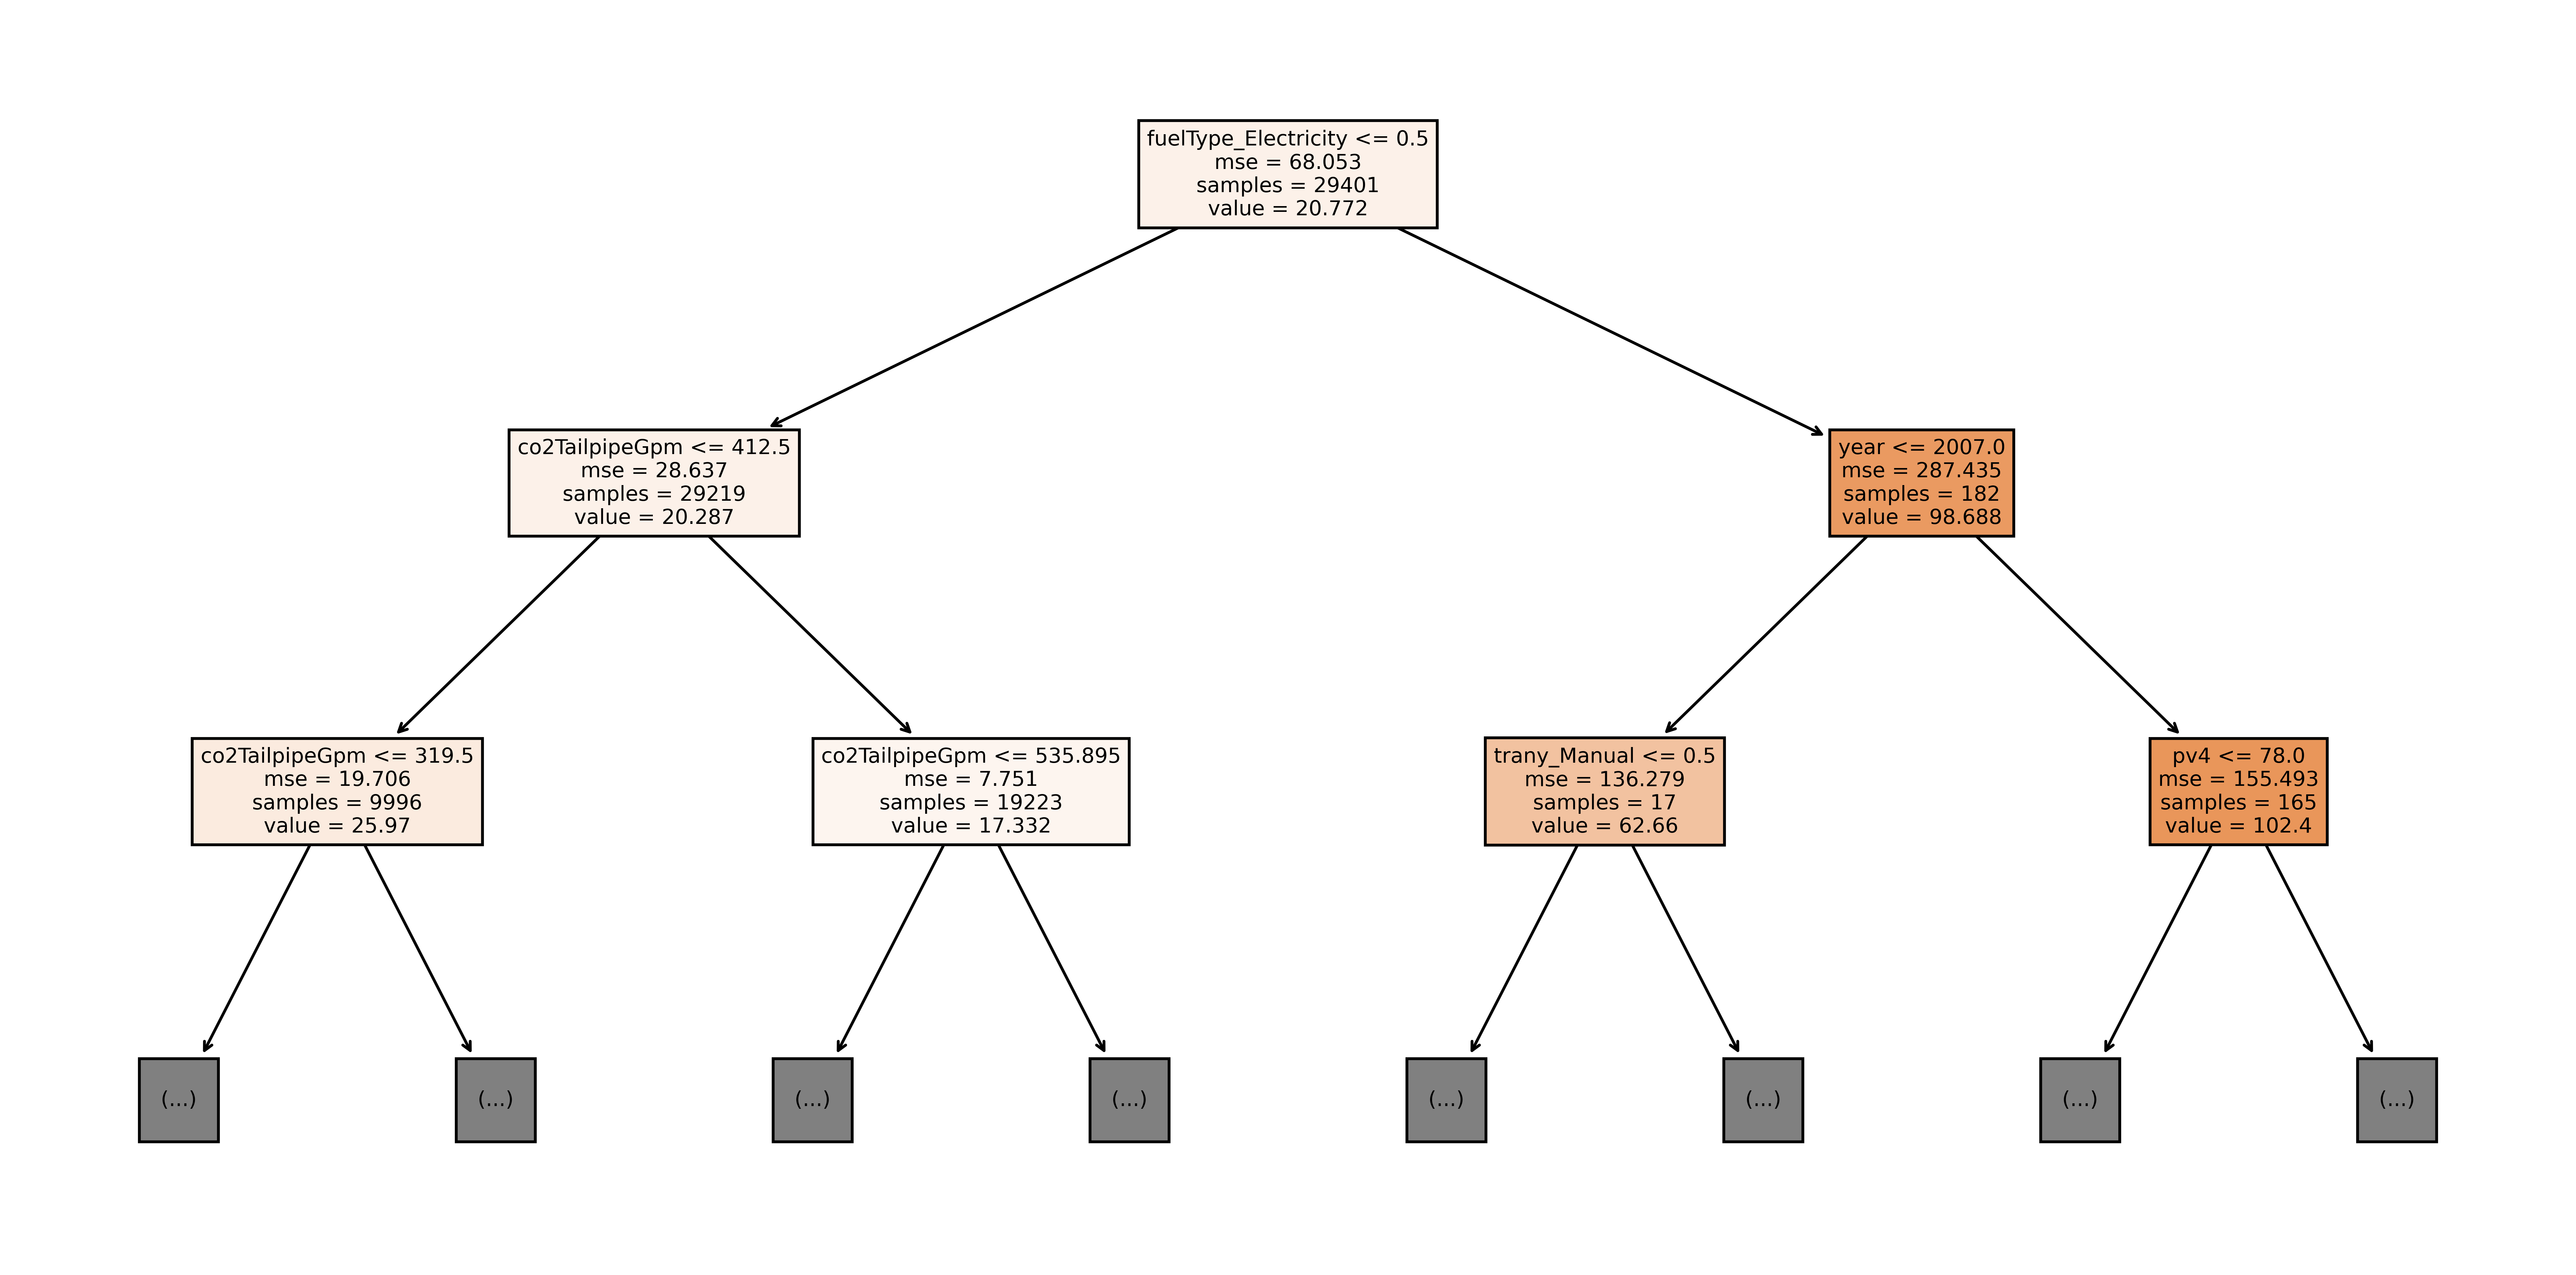

In [48]:
sns.reset_orig()
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8), dpi=600)
tree.plot_tree(fitted_dt_surrogate,\
               feature_names=X_train.columns.values.tolist(), filled = True, max_depth=2)
fig.show()

In [126]:
text_tree = tree.export_text(fitted_dt_surrogate,\
               feature_names=X_train.columns.values.tolist())
print(text_tree)

|--- fuelType_Electricity <= 0.50
|   |--- co2TailpipeGpm <= 412.50
|   |   |--- co2TailpipeGpm <= 319.27
|   |   |   |--- co2TailpipeGpm <= 244.50
|   |   |   |   |--- drive_Front-Wheel <= 0.50
|   |   |   |   |   |--- atvType_Other <= 0.50
|   |   |   |   |   |   |--- co2TailpipeGpm <= 197.88
|   |   |   |   |   |   |   |--- value: [49.74]
|   |   |   |   |   |   |--- co2TailpipeGpm >  197.88
|   |   |   |   |   |   |   |--- value: [38.12]
|   |   |   |   |   |--- atvType_Other >  0.50
|   |   |   |   |   |   |--- co2 <= 92.00
|   |   |   |   |   |   |   |--- value: [34.79]
|   |   |   |   |   |   |--- co2 >  92.00
|   |   |   |   |   |   |   |--- value: [26.77]
|   |   |   |   |--- drive_Front-Wheel >  0.50
|   |   |   |   |   |--- hlv <= 19.50
|   |   |   |   |   |   |--- co2TailpipeGpm <= 213.50
|   |   |   |   |   |   |   |--- value: [43.56]
|   |   |   |   |   |   |--- co2TailpipeGpm >  213.50
|   |   |   |   |   |   |   |--- value: [39.47]
|   |   |   |   |   |--- hlv >  19.50


In [52]:
rulefit_df = fitted_rf_surrogate.get_rules()
rulefit_df = rulefit_df[rulefit_df.coef != 0]
rulefit_df.sort_values(by="importance", ascending=False)